In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import lmdb
import caffe

In [2]:
plt.rcParams['figure.figsize'] = (1, 1)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Have a look a the training data

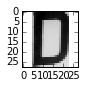

D


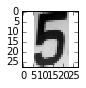

5


In [3]:
env = lmdb.open('test_lmdb')
t = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','0','1','2','3','4','5','6','7','8','9'];

def get(k):
    with env.begin() as txn:
        raw_datum = txn.get(k)

    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)
    flat_x = np.fromstring(datum.data, dtype=np.uint8)
    x = flat_x.reshape(datum.channels, datum.height, datum.width)
    y = datum.label
    plt.imshow(x[0,...],cmap='gray')
    plt.show()
    print t[y]

get(b'00000006')
get(b'00000009')

# Test the network for classification

In [4]:
caffe.set_mode_cpu()
net = caffe.Net('lenet_train_test_withoutdata.prototxt','lenet_iter_2000.caffemodel',caffe.TEST)

In [5]:
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

blobs ['data', 'conv1', 'pool1', 'conv2', 'pool2', 'dropout', 'ip1', 'ip2-alpha']
params ['conv1', 'conv2', 'ip1', 'ip2-alpha']


(-0.5, 27.5, 27.5, -0.5)

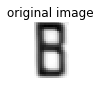

In [6]:
im = np.array(Image.open('input/8.png'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')

In [7]:
im.shape
im_input = im[np.newaxis, np.newaxis, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

The result is B


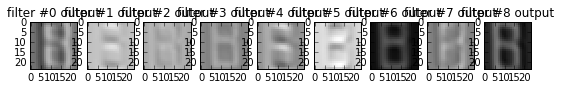

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)
out = net.forward()
plt.figure()
filt_min, filt_max = net.blobs['conv1'].data.min(), net.blobs['conv1'].data.max()
for i in range(9):
    plt.subplot(1,10,i+2)
    plt.title("filter #{} output".format(i))
    plt.imshow(net.blobs['conv1'].data[0, i], vmin=filt_min, vmax=filt_max)
print("The result is {}".format(t[out['ip2-alpha'].argmax()]))

#Feature map
Let's cast the Innerproducts layer 'ip1' and 'ip2-alpha' into convolution layers 'ip1-conv' and 'ip2-alpha-conv'

In [9]:
!diff lenet_train_test_withoutdata.prototxt lenet_train_test_featuremap.prototxt

1c1
< name: "LeNet"
---
> name: "LeNetConv"
82,83c82,83
<   name: "ip1"
<   type: "InnerProduct"
---
>   name: "ip1-conv"
>   type: "Convolution"
85,92c85,86
<   top: "ip1"
<   param {
<     lr_mult: 1
<   }
<   param {
<     lr_mult: 2
<   }
<   inner_product_param {
---
>   top: "ip1-conv"
>   convolution_param {
94,99c88
<     weight_filler {
<       type: "xavier"
<     }
<     bias_filler {
<       type: "constant"
<     }
---
>     kernel_size: 1
105,106c94,95
<   bottom: "ip1"
<   top: "ip1"
---
>   bottom: "ip1-conv"
>   top: "ip1-conv"
109,119c98,102
<   name: "ip2-alpha"
<   type: "InnerProduct"
<   bottom: "ip1"
<   top: "ip2-alpha"
<   param {
<     lr_mult: 1
<   }
<   param {
<     lr_mult: 2
<   }
<   inner_product_param {
---
>   name: "ip2-alpha-conv"
>   type: "Convolution"
>   bottom: "ip1-conv"
>   top: "ip2-alpha-conv"
>   convolution_param {
121,126c104
<     weight_filler {
<       type: "xavier"
<     }
<     bias_filler {
<       type: "constant"
<     }
---
> 

In [10]:
params = ['ip1', 'ip2-alpha']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

ip1 weights are (500, 800) dimensional and biases are (500,) dimensional
ip2-alpha weights are (36, 500) dimensional and biases are (36,) dimensional


In [11]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('lenet_train_test_featuremap.prototxt','lenet_iter_2000.caffemodel',caffe.TEST)
params_full_conv = ['ip1-conv', 'ip2-alpha-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

ip1-conv weights are (500, 50, 1, 1) dimensional and biases are (500,) dimensional
ip2-alpha-conv weights are (36, 500, 1, 1) dimensional and biases are (36,) dimensional


In [12]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

In [13]:
net_full_conv.save('lenet_train_test__full_conv.caffemodel')

(322, 800, 3)

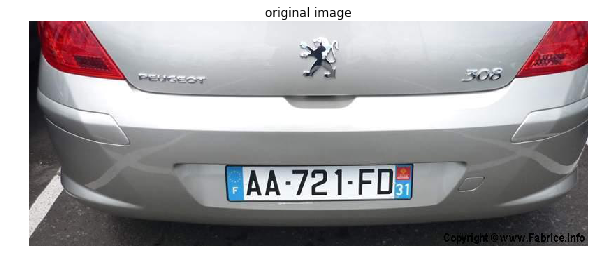

In [14]:
plt.rcParams['figure.figsize'] = (10, 5)
im = np.array(Image.open('input/p1.jpg'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')
im.shape

(290, 720)

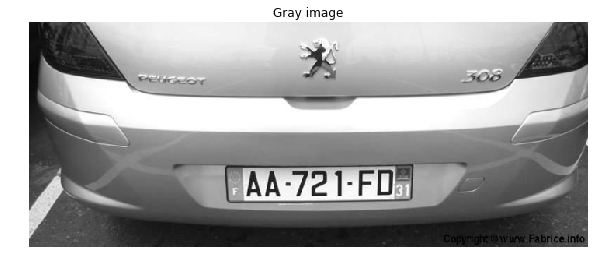

In [15]:
import cv2
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im_gray = cv2.resize(im_gray,None, fx=0.9, fy=0.9, interpolation = cv2.INTER_AREA)
plt.title("Gray image")
plt.imshow(im_gray)
plt.axis('off')
im_gray.shape

In [16]:
im_input = im_gray[np.newaxis, np.newaxis, :, :]
net_full_conv.blobs['data'].reshape(*im_input.shape)
net_full_conv.blobs['data'].data[...] = im_input

In [17]:
out = net_full_conv.forward()
out['ip2-alpha-conv'].shape

(1, 36, 70, 177)

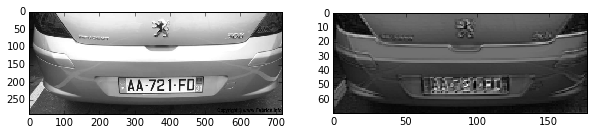

In [19]:
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(net_full_conv.blobs['data'].data[0,0])
plt.subplot(1, 2, 2)
plt.imshow(out['ip2-alpha-conv'][0,0] )